In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
from open_frame import open_frame as OF
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"

# Results

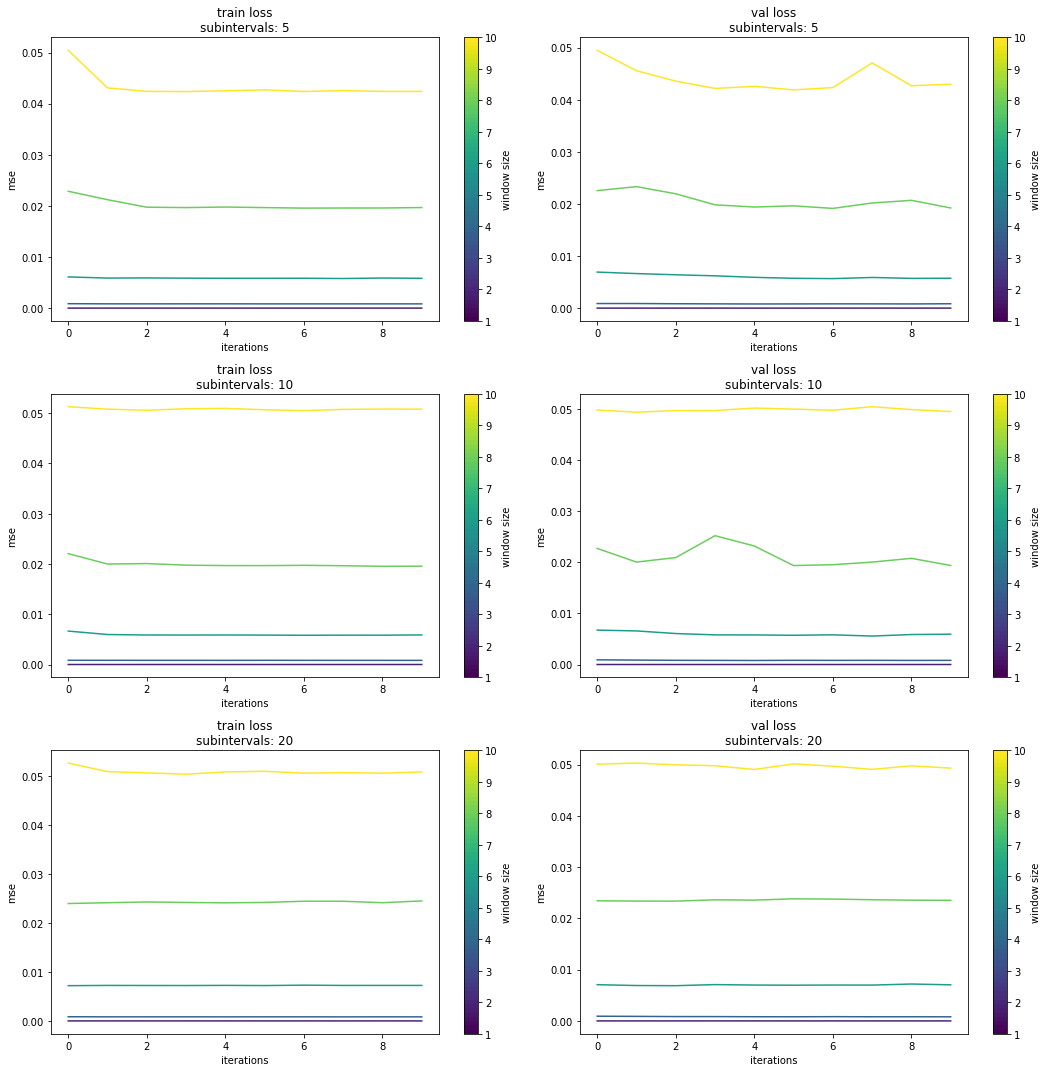

In [2]:
classes = np.unique([int(i.split('_')[-1][:-4]) for i in glob(f'./history/dec_{typ}*')])

fig,axs = plt.subplots(nrows = len(classes),ncols=2,figsize=(15,15))

for num,num_classes in enumerate(classes):

    n = np.array([float(i.split('_')[-2]) for i in glob(f'./history/dec_{typ}_*_{num_classes}.npy')])//0.15
    if len(n) == 0:
        continue
    n = int(np.amax(n)) + 1 
    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, n))
    newcmp = ListedColormap(colors)

    try:
        w = [float(i.split('_')[-2]) for i in glob(f'./history/dec_{typ}_*_{num_classes}.npy')]
    except:
        continue

    ylab = ['mse','mse']
    titles = ['train loss','val loss']
    norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))
    ct = [tuple(i) for i in colors]

    trained = glob(f'./history/dec_{typ}*_{num_classes}.npy')
    for m,i in enumerate(trained):
        hist = np.load(i)
        c = int(float(i.split('_')[-2])//0.15)
        for j in range(len(hist)-1):

            if j%2 == 0:
                im = axs[num,j].plot(np.array(hist[j]),color = colors[c])
            else:
                im = axs[num,j].plot(np.array(hist[j]),color = colors[c])

            axs[num,j].set_title(f'{titles[j]}\nsubintervals: {num_classes}')
            axs[num,j].set_xlabel('iterations')
            axs[num,j].set_ylabel(ylab[int(j%2)])





    for j in range(len(hist)-1):
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[num,j],label='window size')
        #plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[j],label='window size')
plt.tight_layout()
plt.show()

# Results with first function

In [3]:
num_classes = 20
model = get_model("decreasing",it_lim=10,image_size=image_size,num_classes = num_classes)

2023-01-14 16:01:12.681886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 16:01:12.682101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 16:01:12.708235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 16:01:12.708466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 16:01:12.708636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

2023-01-14 16:01:17.466557: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2023-01-14 16:01:18.324099: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


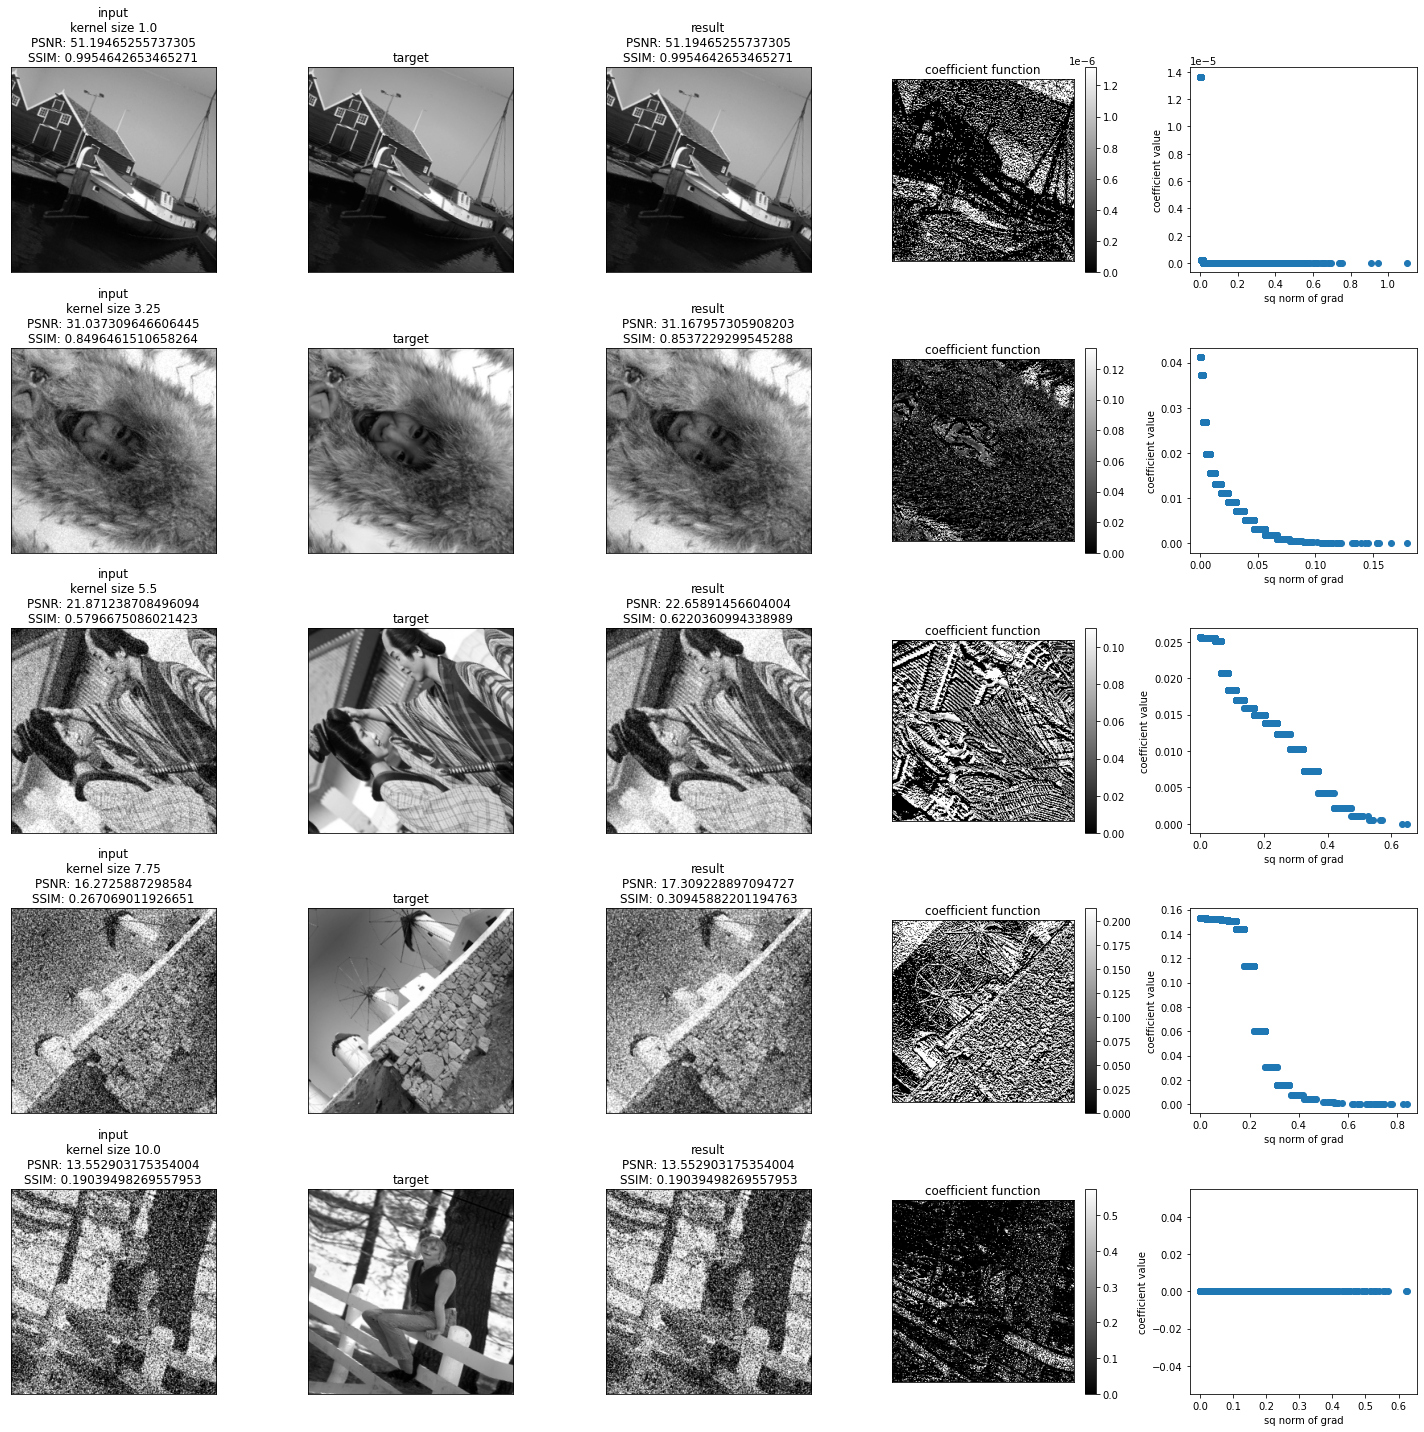

In [4]:
w = np.unique([float(i.split('_')[-2]) for i in glob(f'./checkpoints/dec_{typ}_*_{num_classes}.index')])
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(20,20))
for i,m in enumerate(w):

        
    model.load_weights(f'./checkpoints/dec_{typ}_{w[i]}_{num_classes}')
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    _ = np.random.choice(len(ims[0]))
    im = ims[:,_,...]
    im = np.asarray(im,dtype='float32')
    p = model(ims[0])
    
    psnr_0 = tf.image.psnr(np.array([im[0]]),np.array([im[1]]),1)[0]
    ssim_0 = tf.image.ssim(np.array([im[0]]),np.array([im[1]]),1)[0]
    clean = p[_]
    psnr = tf.image.psnr(np.array([im[1]]),clean,1)[0]
    ssim = tf.image.ssim(np.array([im[1]]),clean,1)[0]
    inputs = tf.keras.Input(shape=image_size + (1,))
    visualization = tf.keras.models.Model(model.input,model.get_layer('coeff_x_0').output)
    vis = visualization(np.array([np.expand_dims(im[1],axis=-1)]))
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('simple_extract').output)
    spline = np.squeeze(get_lambdas(np.array([np.expand_dims(im[0],axis=-1)])))
    norm_layer = tf.keras.models.Model(model.input,model.get_layer('norm').output)
    norm = np.squeeze(norm_layer(np.array([np.expand_dims(im[1],axis=-1)])))
    partition_layer = tf.keras.models.Model(model.input,model.get_layer('partition').output)
    partition = np.squeeze(partition_layer(np.array([np.expand_dims(im[1],axis=-1)])))
    
    
    axs[i,0].imshow(im[0],cmap='gray')
    axs[i,0].set_title(f'input\nkernel size {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(im[1],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(np.squeeze(vis[0]),cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    N = np.ndarray.flatten(norm)
    loc = np.logical_and(N < np.expand_dims(partition[1:],axis=-1),N >= np.expand_dims(partition[:-1],axis=-1))
    
    coeff_plot = np.multiply(loc.T,np.multiply(np.expand_dims(spline,axis=0),np.ones_like(loc.T)))
    
    fc = np.sum(coeff_plot,axis=-1)
    axs[i,4].scatter(N,fc)
    axs[i,4].set_xlabel("sq norm of grad")
    axs[i,4].set_ylabel("coefficient value")
    
plt.tight_layout()
plt.show()

# Comparing againts Perona Malik

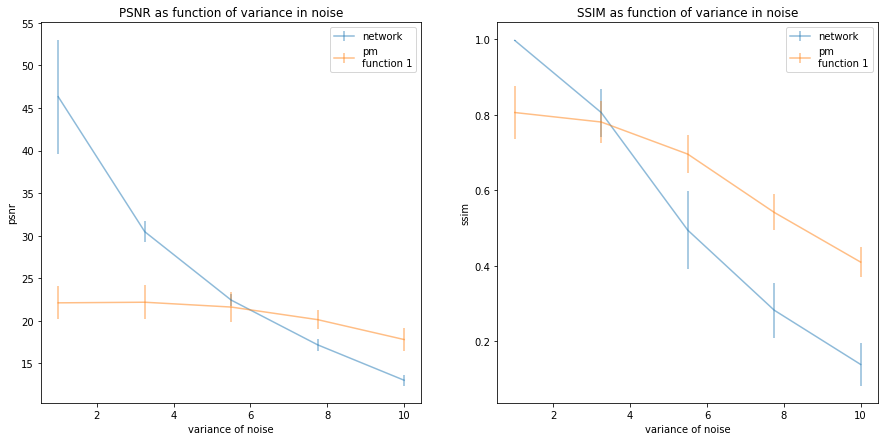

In [5]:
num_classes = 20

trained = glob(f'./history/dec_{typ}*_{num_classes}.npy')
w = np.unique([float(i.split('_')[2]) for i in trained])
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

for i,m in enumerate(w):
    model = get_model("decreasing",it_lim=10,image_size=image_size,num_classes = num_classes)
    model.load_weights(f"./checkpoints/dec_{typ}_{w[i]}_{num_classes}")
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=100)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    
    res = model(ims[0])
    res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
    psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_nn_1.append(np.mean(psnr))
    psnr_nn_s_1.append(np.std(psnr))
    ssim_nn_1.append(np.mean(ssim))
    ssim_nn_s_1.append(np.std(ssim))
    
    pm = np.expand_dims([np.squeeze(anisodiff(im,niter=10,lambd=50,option=1)) for im in ims[0]],axis=-1)
    pm = np.asarray(pm,dtype='float32')
    psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_pm_1.append(np.mean(psnr))
    psnr_pm_s_1.append(np.std(psnr))
    ssim_pm_1.append(np.mean(ssim))
    ssim_pm_s_1.append(np.std(ssim))
    
    

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)

#plt.errorbar(w,psnr_nn_2,psnr_nn_s_2,label='network\nfunction 2',alpha=0.5)
#plt.errorbar(w,psnr_pm_2,psnr_pm_s_2,label='pm\nfunction 2',alpha=0.5)
plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

# Analizing functions for coefficients

In [6]:
R = []
ncl = np.array([int(i.split('_')[-1].split('.')[0]) for i in glob(f'./checkpoints/dec_{typ}_*.index')])
ncl = np.unique(ncl)

for num_classes in ncl:
    R.append([])
    model = get_model("decreasing",it_lim=10,image_size=image_size,num_classes = num_classes)
    w = np.unique([float(i.split('_')[-2]) for i in glob(f'./checkpoints/dec_{typ}_*_{num_classes}.index')])
    
    for i,m in enumerate(tqdm(w)):

        
        model.load_weights(f"./checkpoints/dec_{typ}_{w[i]}_{num_classes}")
        
        #temp_mean = [[] for c in range(num_classes)]
        temp_mean = []
        gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=50)
        xs, ys = next(gen_batch_train.as_numpy_iterator())
        for _ in range(len(xs)):

            get_lambdas = tf.keras.models.Model(model.input,model.get_layer('simple_extract').output)
            spline = np.squeeze(get_lambdas(np.array([np.expand_dims(xs[_],axis=-1)])))
            
            temp_mean.append(np.copy(spline))

       
        mean = np.mean(temp_mean,axis=0)
        std = np.std(temp_mean,axis=0)
        R[-1].append(np.transpose([mean,std]))

100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


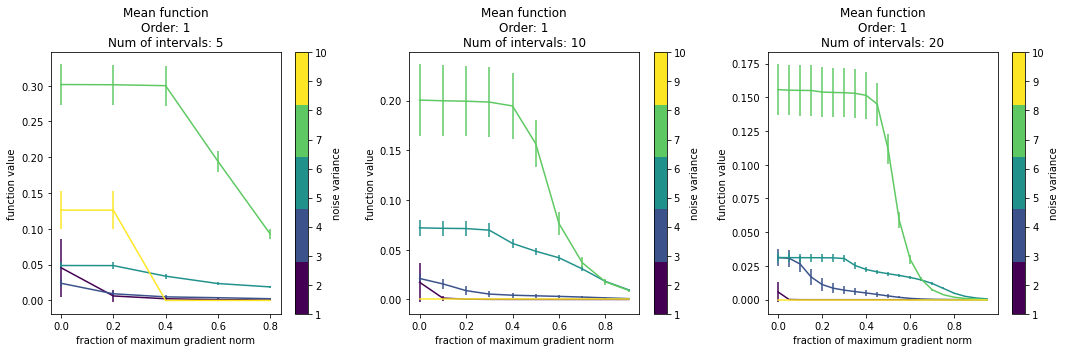

In [7]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = len(R),nrows = 1,figsize=(15,5))
orders,num_classes = [1,2,3,5],[5,10,20]

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        m,s = R[col][i].T

        axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])

    axs[col].set_title(f"Mean function\nOrder: {1}\nNum of intervals: {ncl[col]}")
    axs[col].set_xlabel("fraction of maximum gradient norm")
    axs[col].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col],label='noise variance')

plt.tight_layout()        
plt.show()